# Step 0: Get Background intensity for RHL and HQNO reporters

This notebook determines background intensity values for RHL and HQNO fluorescent reporters by:
1. Loading calibration data for 0-concentration controls (RHL_0_µg and HQNO_0_ng)
2. Analyzing intensity distributions using histogram peak detection with Gaussian smoothing
3. Identifying the modal (peak) intensity value as the background signal
4. Saving background values to JSON file for use in downstream analysis

**Output generated:**
- JSON file (`background_intensities.json`) containing background values for both reporters

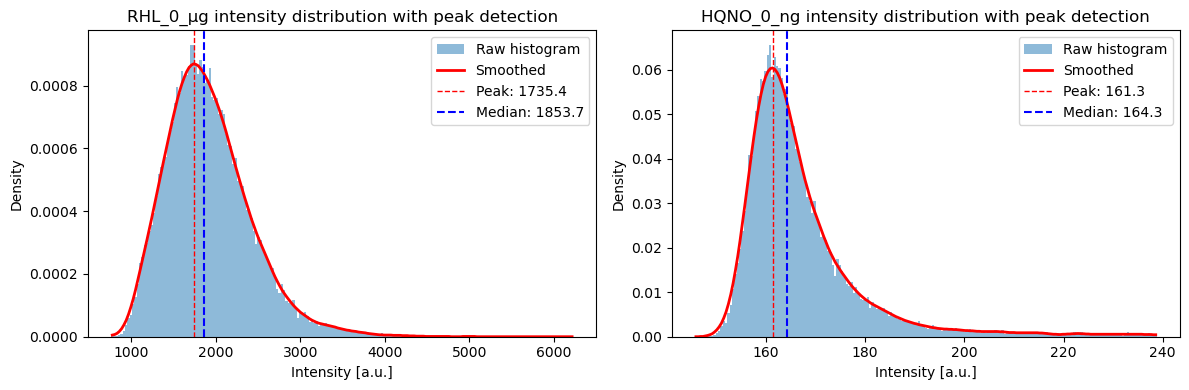

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

data_path = Path.cwd().parent / 'datafiles'


control_settings = {
    'RHL': {'file_name': 'rhl_calibration_microscopy.csv',
            'channel': 'intensity_raw_mcherry',
            'condition': 'RHL_0_µg'},
    'HQNO': {'file_name': 'hqno_calibration_microscopy.csv',
             'channel': 'intensity_raw_gfp',
             'condition': 'HQNO_0_ng'}
}


fig, axs = plt.subplots(1, len(control_settings), figsize=(12, 4))


for i, (reporter, settings) in enumerate(control_settings.items()):
    path = data_path / settings['file_name']
    channel = settings['channel']
    condition = settings['condition']
    
    df_control = pd.read_csv(path)
    df_control_condition = df_control[df_control[reporter] == condition]

    intensities = df_control_condition[channel].values

    # trim the intensity range for better peak detection
    min_intensity = np.min(intensities)
    median_intensity = np.median(intensities)
    max_fitted_intensity = median_intensity + 4 * (median_intensity - min_intensity)

    bins = np.linspace(min_intensity, max_fitted_intensity, 200)

    # Create histogram with appropriate bins
    hist_counts, hist_bins = np.histogram(intensities, bins=bins)

    # Apply Gaussian smoothing to reduce noise
    smoothed_counts = gaussian_filter1d(hist_counts, sigma=3)

    # Find peaks in the smoothed histogram
    peaks, properties = find_peaks(smoothed_counts, prominence=0.1*smoothed_counts.max())

    # Visualize the peak detection
    axs[i].hist(intensities, bins=bins, alpha=0.5, label='Raw histogram', density=True)
    
    # Plot smoothed curve
    bin_centers = (hist_bins[:-1] + hist_bins[1:]) / 2
    axs[i].plot(bin_centers, smoothed_counts / np.sum(smoothed_counts) / np.diff(bins)[0], 
            'r-', linewidth=2, label='Smoothed')


    # Get the highest peak (mode of distribution)
    if len(peaks) > 0:
        highest_peak_idx = peaks[np.argmax(smoothed_counts[peaks])]
        peak_intensity = (hist_bins[highest_peak_idx] + hist_bins[highest_peak_idx + 1]) / 2
        control_settings[reporter]['bg_value'] = peak_intensity
    
        # Mark the peak
        axs[i].axvline(peak_intensity, color='red', linestyle='--', 
                       linewidth=1, label=f'Peak: {peak_intensity:.1f}')
        axs[i].axvline(median_intensity, color='blue', linestyle='--', 
                label=f'Median: {median_intensity:.1f}')
   
    else:
        print("No peaks found in the distribution")
        control_settings[reporter]['bg_value'] = np.nan

    axs[i].set_xlabel('Intensity [a.u.]')
    axs[i].set_ylabel('Density')
    axs[i].set_title(f'{condition} intensity distribution with peak detection')
    axs[i].legend()

# Move plt.tight_layout() and plt.show() outside the loop
plt.tight_layout()
plt.show()


OUTPUT_JSON = Path.cwd() / 'data' / 'background_intensities.json'
with open(OUTPUT_JSON, 'w') as f:
    json.dump(control_settings, f, indent=2)

